In [71]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input now consist of a first stimulus, followed by a delay and the second stimulus

$
u(t) = 
\begin{cases}
u_1, & \text{if } 5 \le t \le 10 \\
u_2, & \text{if } 60 \le t \le 70 \\
0, & \text{otherwise}
\end{cases}
$ 

The two stimuli are defined as

$
u_i = \frac{1}{f_{max} - f_{min}} (f_i - \frac{f_{max} + f_{min}}{2}), i = 1,2
$ 

with $f_i$ sampled uniformly from the set {10, 14, 18, 22, 26, 30, 34}, and $f_{min} = 10, f_{max} = 34$ the smallest and largest elements of that set. The target output y is the normalized difference between the stimuli:

$
y = \frac{f_1 - f_2}{f_{max} - f_{min}}
$

Note that in the paper, they use random delays and more points fi. Discuss how that potentially affects the solution.



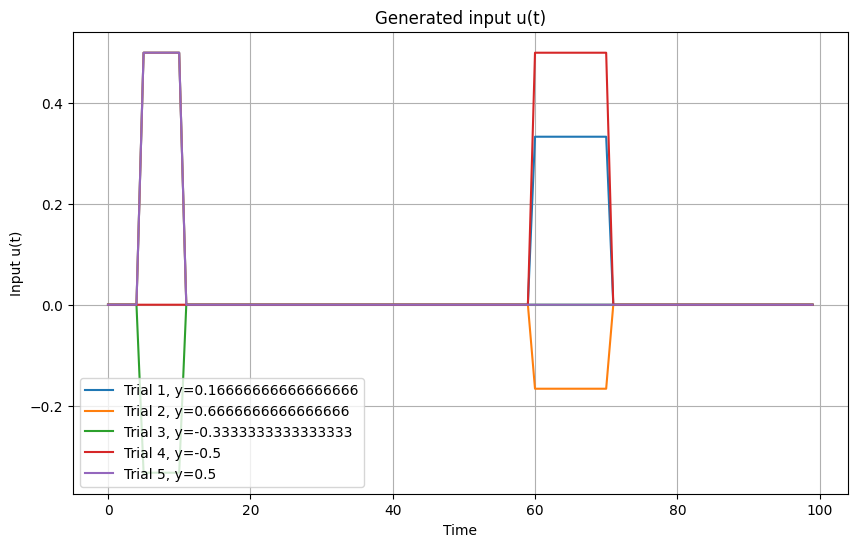

In [90]:
def compute_stimulus(fmin, fmax, f):
    u_i = 1/(fmax - fmin) * (f - (fmax + fmin)/2)
    return u_i


def create_input_data(time):
    u = np.zeros(len(time))
    possible_f = np.array([10, 14, 18, 22, 26, 30, 34])
    f_min = possible_f.min()
    f_max = possible_f.max()
    f_1 = np.random.choice(possible_f)
    f_2 = np.random.choice(possible_f)

    for idx, t_val in enumerate(time):
        if 5 <= t_val <= 10:
            u[idx] = compute_stimulus(f_min, f_max, f_1)
        elif 60 <= t_val <= 70:
            u[idx] = compute_stimulus(f_min, f_max, f_2)
        else:
            u[idx] = 0

    y = (f_1 - f_2) / (f_max - f_min)
    return u, y


def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()


## 2. Recurrent Neural Network Initialization

Extend your network implementation to allow for recurrent connectivity of arbitrary rank.


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim 

# RNN Model of arbitary rank
class RNNModel(nn.Module): 
    def __init__(self, N, rank):
        super(RNNModel, self).__init__()
        self.N = N
        self.rank = rank
        self.m = nn.Parameter(torch.randn(rank, N))
        self.n = nn.Parameter(torch.randn(rank, N))
        self.I = torch.randn(N)
        self.w = torch.randn(N) * 4  
        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):
        B, T = u_batch.shape
        x = torch.zeros(B, self.N, device=u_batch.device)  # per batch initialization
        z_out = []
        x_traj = [] 

        for t in range(T):
            u_t = u_batch[:, t]  # (B,)
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n.T) @ self.m
            dx = (-x + J_phi + u_t.unsqueeze(1) * self.I) * (self.dt / self.tau)
            x = x + dx
            z_t = (phi_x @ self.w) / self.N  
            z_out.append(z_t)
            x_traj.append(x)
        x_traj = torch.stack(x_traj, dim=1)  
        z_out = torch.stack(z_out, dim=1)  # (B, T)
        return x_traj, z_out


## 3. Training the network

Train a network of size N = 128 and rank R = 2 by minimizing the mean squared error between the target and the network output during the last 5 time steps of each trial. The loss should drop below 5e-3. If it does not, make sure to visualize your data and the networks output, and try debugging the network using the tips from exercise 1. 


Step 0, Loss: 0.2791
Step 100, Loss: 0.1144
Step 200, Loss: 0.1167
Step 300, Loss: 0.1218
Step 400, Loss: 0.0859
Step 500, Loss: 0.1635
Step 600, Loss: 0.1309
Step 700, Loss: 0.1324
Step 800, Loss: 0.1372
Step 900, Loss: 0.0965
Step 1000, Loss: 0.0793
Step 1100, Loss: 0.1134
Step 1200, Loss: 0.1076
Step 1300, Loss: 0.0948
Step 1400, Loss: 0.1293
Step 1500, Loss: 0.1424
Step 1600, Loss: 0.1179
Step 1700, Loss: 0.0952
Step 1800, Loss: 0.1371
Step 1900, Loss: 0.1192
Step 2000, Loss: 0.0973
Training stopped at step 2000 with loss 0.0973


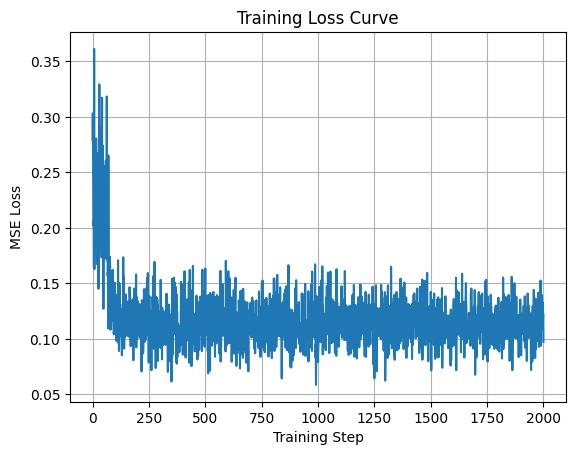

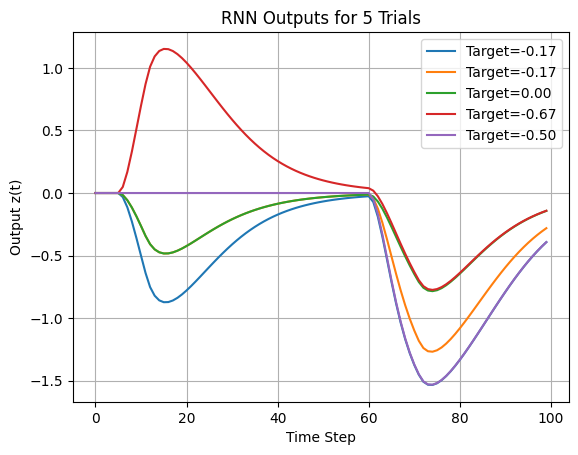

In [77]:
# Settings
N = 128
stop_loss = 5e-3
max_steps = 2_000 
R = 2

batch_size = 32
lr = 5e-3
T_total = 100
T_eval = 5


def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)  
    y = np.array(df['y'].values)  
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


model = RNNModel(N=N, rank=R)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

losses = []
step = 0
while True:
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size)
    _, z = model(u_batch)
    z_decision = z[:, -T_eval:]
    y_exp = y_batch.unsqueeze(1).expand_as(z_decision)
    loss = loss_fn(z_decision, y_exp)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    losses.append(loss.item())

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
    
    if loss.item() < stop_loss or step >= max_steps:
        print(f"Training stopped at step {step} with loss {loss.item():.4f}")
        break

    step += 1

# Plot loss
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# Visualize network outputs
with torch.no_grad():
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size=5)
    x, z = model(u_batch)
    for i in range(5):
        plt.plot(z[i].numpy(), label=f"Target={y_batch[i]:.2f}")
    plt.title("RNN Outputs for 5 Trials")
    plt.xlabel("Time Step")
    plt.ylabel("Output z(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. Connectivity

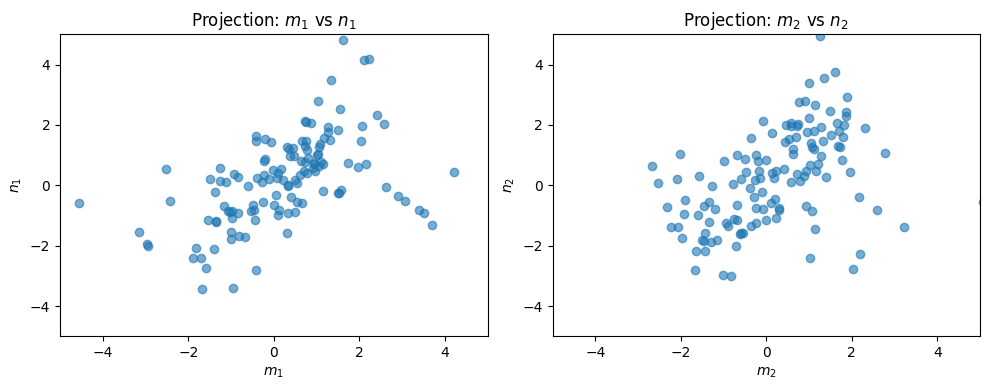

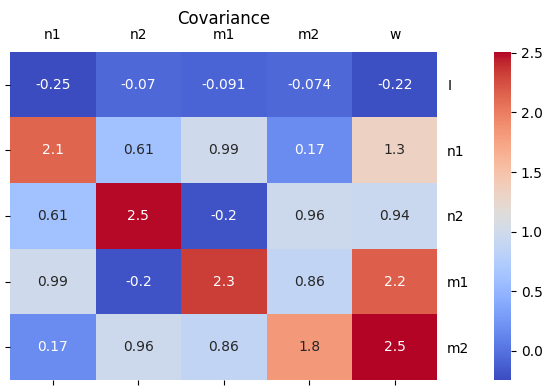

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_connectivity_patterns(model):
    m = model.m.detach().cpu().numpy() 
    n = model.n.detach().cpu().numpy()  
    w = model.w.detach().cpu().numpy() 
    I = model.I.detach().cpu().numpy()

    # Projections: scatter m_i vs n_i (for each mode)
    m1, m2 = m[0], m[1]
    n1, n2 = n[0], n[1]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(m1, n1, alpha=0.6)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel(r"$m_1$")
    plt.ylabel(r"$n_1$")
    plt.title(r"Projection: $m_1$ vs $n_1$")

    plt.subplot(1, 2, 2)
    plt.scatter(m2, n2, alpha=0.6)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel(r"$m_2$")
    plt.ylabel(r"$n_2$")
    plt.title(r"Projection: $m_2$ vs $n_2$")
    plt.tight_layout()
    plt.show()

    # Covariances of patterns 
    patterns = np.stack([I, n[0], n[1], m[0], m[1], w], axis=0)
    labels = ['I', 'n1', 'n2', 'm1', 'm2', 'w']
    cov = np.cov(patterns)

    row_idxs = [0, 1, 2, 3, 4]  # I, n1, n2, m1, m2
    col_idxs = [1, 2, 3, 4, 5]  # n1, n2, m1, m2, w
    cov_sub = cov[np.ix_(row_idxs, col_idxs)]
    row_labels = ['I', 'n1', 'n2', 'm1', 'm2']
    col_labels = ['n1', 'n2', 'm1', 'm2', 'w']

    # Plot
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    sns.heatmap(cov_sub, annot=True, cmap='coolwarm',
                xticklabels=col_labels, yticklabels=row_labels,
                cbar_kws={"pad": 0.1})
    
    # Format: move labels to right/top
    ax.tick_params(
        labelleft=False, labelbottom=False,
        labelright=True, labeltop=True, rotation=0
    )
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    plt.title("Covariance", pad=20)
    plt.tight_layout()
    plt.show()

plot_connectivity_patterns(model)

## 5. Activity

Project the N-dimensional activity onto the m1,m2, to obtain latent variables κ1,κ2. Is their activity showing the two time scales you might expect from the connectivity patterns?

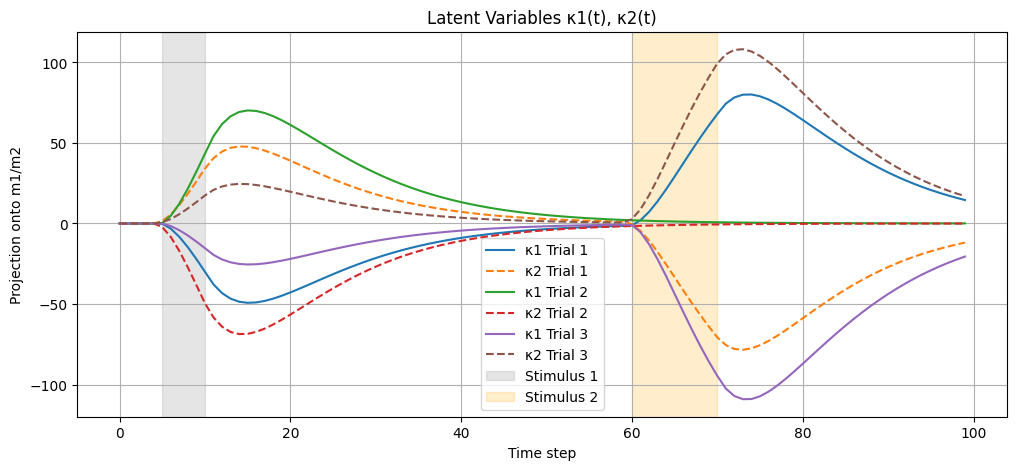

In [ ]:
# project activity onto m1, m2

def project_activity_on_m(model, x_traj):  
    # x_traj: (B, T, N)
    m = model.m.detach().cpu().numpy()      # (2, N)
    x = x_traj.detach().cpu().numpy()       # (B, T, N)

    kappa1 = np.einsum('btn,n->bt', x, m[0])  # dot with m1
    kappa2 = np.einsum('btn,n->bt', x, m[1])  # dot with m2
    return kappa1, kappa2

# Run model on one batch
with torch.no_grad():
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size=5)
    x, z = model(u_batch)

kappa1, kappa2 = project_activity_on_m(model, x)  # shapes: (5, T)

# Plot for 3 trials
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(kappa1[i], label=f'κ1 Trial {i+1}', linestyle='-')
    plt.plot(kappa2[i], label=f'κ2 Trial {i+1}', linestyle='--')
plt.axvspan(5, 10, color='gray', alpha=0.2, label='Stimulus 1')
plt.axvspan(60, 70, color='orange', alpha=0.2, label='Stimulus 2')
plt.title("Latent Variables κ1(t), κ2(t)")
plt.xlabel("Time step")
plt.ylabel("Projection onto m1/m2")
plt.legend()
plt.grid(True)
plt.show()

    

Fast dynamics - $\kappa_1$ rising quickly during stimulus 1, decaying after - suggest a transient integration mode.

Slow drift between stimuli - $\kappa_2$ - reflect longer memory time scales, possibly along a nearly line attractor or integrator axis.

## 6. Connectivity - Guassian approximation 

Test if the covariance patterns characterize the network connectivity by fitting and resampling a 6-dimensional Gaussian to the connectivity patterns.

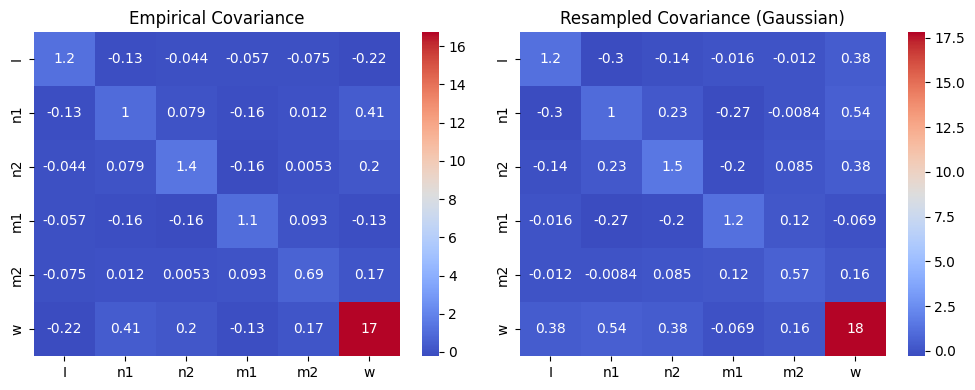

In [ ]:
import seaborn as sns

def test_connectivity_by_gaussian(model):
    # Extract patterns: each of shape (N,)
    m = model.m.detach().cpu().numpy()
    n = model.n.detach().cpu().numpy()
    I = model.I.detach().cpu().numpy()
    w = model.w.detach().cpu().numpy()

    # Patterns: shape (6, N)
    patterns = np.stack([I, n[0], n[1], m[0], m[1], w], axis=0)
    labels = ['I', 'n1', 'n2', 'm1', 'm2', 'w']

    # Fit Gaussian: across neurons (each neuron is a sample in 6D)
    patterns_T = patterns.T  # shape (N, 6)
    mean = np.mean(patterns_T, axis=0)     # (6,)
    cov = np.cov(patterns_T, rowvar=False) # (6, 6)

    # Resample synthetic patterns
    np.random.seed(0)
    synthetic = np.random.multivariate_normal(mean, cov, size=patterns_T.shape[0])  # (N, 6)
    synthetic = synthetic.T  # shape back to (6, N)

    # Compute covariances
    cov_real = np.cov(patterns)
    cov_synth = np.cov(synthetic)

    # Plot both covariances side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(cov_real, ax=axes[0], annot=True, cmap='coolwarm',
                xticklabels=labels, yticklabels=labels)
    axes[0].set_title("Empirical Covariance")

    sns.heatmap(cov_synth, ax=axes[1], annot=True, cmap='coolwarm',
                xticklabels=labels, yticklabels=labels)
    axes[1].set_title("Resampled Covariance (Gaussian)")

    plt.tight_layout()
    plt.show()

test_connectivity_by_gaussian(model)

## 7. equivalent circuit

Under the appropriate assumptions, the trained network can now be described by a two-dimensional equivalent circuit. Its dynamics are given by

$
\frac{d \kappa_1}{dt} = - \kappa_1 + \tilde{\sigma_{m1n1}} \kappa_1 + \tilde{\sigma_{n1I}}v(t) \\
\frac{d \kappa_2}{dt} = - \kappa_2 + \tilde{\sigma_{m2n2}} \kappa_2 + \tilde{\sigma_{n2I}}v(t) \\
$

The coupling terms again encapsulate the system’s nonlinearity, here via the scaling

$
\Delta = \sqrt{\sigma_{m1}^2 \kappa_1^2 + \sigma_{m2}^2 \kappa_2^2 + \sigma_I^2v^2}
$

Simulate the effective circuit for different inputs v. 

The circuit should perform qualitatively, but not necessarily quantitatively, the same as the full network. If it does not, try using the covariances reported in the paper: 
$\sigma_{n1m1} = 1, \sigma_{n2m2} = 0.5, \sigma_{n1I} = 0.5, \sigma_{n2I} = 1.9, \sigma_{m1w} = 2.8, \sigma_{m2w} = −2.2$

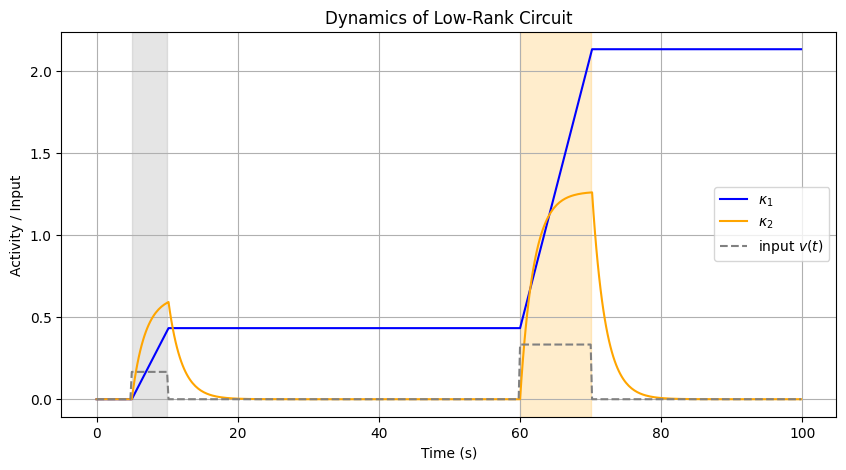

In [91]:

T = 100
dt = 0.2
time = np.arange(0, T, dt)



def simulate_equivalent_circuit(time, input_func=None,
                                sigma_mn=(1.0, 0.5), sigma_nI=(0.5, 1.9)):

    steps = len(time)
    kappa1 = np.zeros(steps)
    kappa2 = np.zeros(steps)
    v = np.zeros(steps) if input_func is None else input_func(np.arange(steps))

    for t in range(1, steps):
        dk1 = (-kappa1[t-1] + sigma_mn[0] * kappa1[t-1] + sigma_nI[0] * v[t-1]) * dt
        dk2 = (-kappa2[t-1] + sigma_mn[1] * kappa2[t-1] + sigma_nI[1] * v[t-1]) * dt
        kappa1[t] = kappa1[t-1] + dk1
        kappa2[t] = kappa2[t-1] + dk2

    return kappa1, kappa2, v

example_input = create_input_data(time)[0]

k1, k2, v = simulate_equivalent_circuit(
    time,
    input_func=lambda t_idx: example_input  # returns full vector, ignores t_idx
)

plt.figure(figsize=(10, 5))
plt.plot(time, k1, label=r'$\kappa_1$', color='blue')
plt.plot(time, k2, label=r'$\kappa_2$', color='orange')
plt.plot(time, v, label='input $v(t)$', linestyle='dashed', color='gray')
plt.axvspan(5, 10, color='gray', alpha=0.2)
plt.axvspan(60, 70, color='orange', alpha=0.2)
plt.title("Dynamics of Low-Rank Circuit")
plt.xlabel("Time (s)")
plt.ylabel("Activity / Input")
plt.legend()
plt.grid(True)
plt.show()